In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import linregress
from scipy.optimize import minimize
from lifelines import WeibullFitter
from lifelines.utils import concordance_index


In [33]:
df = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')

In [34]:
kmf = KaplanMeierFitter()
kmf.fit(df['time'], event_observed=df['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 686 total observations, 387 right-censored observations>

In [35]:
time_points = kmf.survival_function_.index
survival_probs = kmf.survival_function_['KM_estimate']
log_log_survival = np.log(-np.log(survival_probs))
log_time = np.log(time_points)


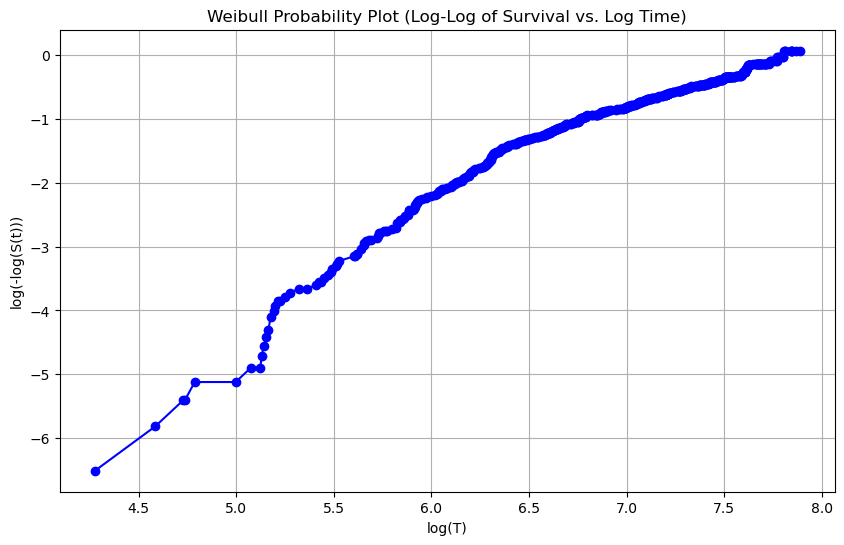

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(log_time, log_log_survival, marker='o', linestyle='-', color='blue')
plt.title('Weibull Probability Plot (Log-Log of Survival vs. Log Time)')
plt.xlabel('log(T)')
plt.ylabel('log(-log(S(t)))')
plt.grid(True)
plt.show()


In [37]:
def estimate_weibull_params(data, time_col='time', event_col='status'):
    # Fit the Kaplan-Meier estimator
    kmf = KaplanMeierFitter()
    kmf.fit(data[time_col], event_observed=data[event_col])

    # Transform the survival function
    time_points = kmf.survival_function_.index
    survival_probs = kmf.survival_function_['KM_estimate']
    log_log_survival = np.log(-np.log(survival_probs))
    log_time = np.log(time_points)

    # Filter out infinite values resulting from log(0)
    valid_idx = np.isfinite(log_log_survival) & np.isfinite(log_time)
    log_log_survival = log_log_survival[valid_idx]
    log_time = log_time[valid_idx]

    # Perform linear regression on the transformed data
    slope, intercept, _, _, _ = linregress(log_time, log_log_survival)

    # Calculate alpha and beta
    alpha = slope
    beta = np.exp(-intercept / alpha)

    # Plot the data and regression line for visualization
    plt.figure(figsize=(10, 6))
    plt.plot(log_time, log_log_survival, 'o', label='Transformed data')
    plt.plot(log_time, slope * log_time + intercept, 'r-', label=f'Fit line (alpha={alpha:.2f}, beta={beta:.2f})')
    plt.title('Weibull Probability Plot (Log-Log of Survival vs. Log Time)')
    plt.xlabel('log(T)')
    plt.ylabel('log(-log(S(t)))')
    plt.grid(True)
    plt.legend()
    plt.show()

    return alpha, beta

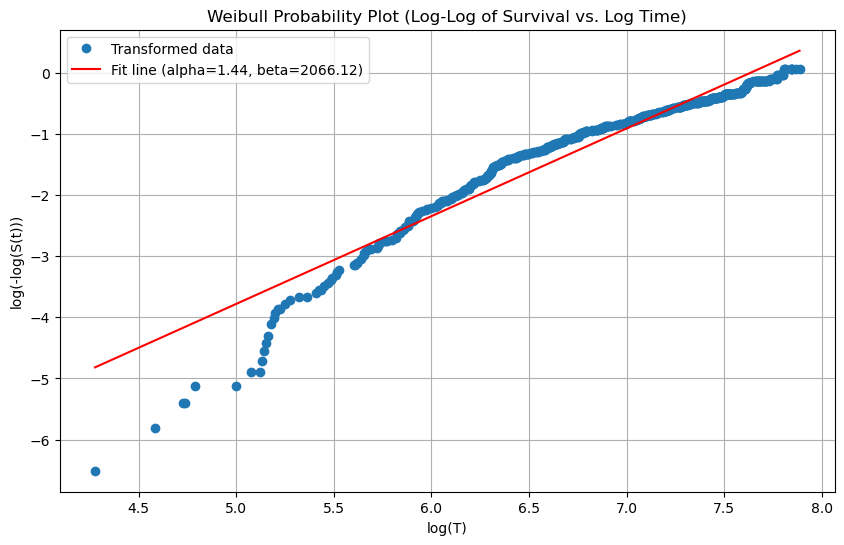

Estimated alpha (shape): 1.44
Estimated beta (scale): 2066.12


In [38]:
alpha_est, beta_est = estimate_weibull_params(df)
print(f"Estimated alpha (shape): {alpha_est:.2f}")
print(f"Estimated beta (scale): {beta_est:.2f}")

In [39]:
df['time'] = df['time'] / df['time'].max()

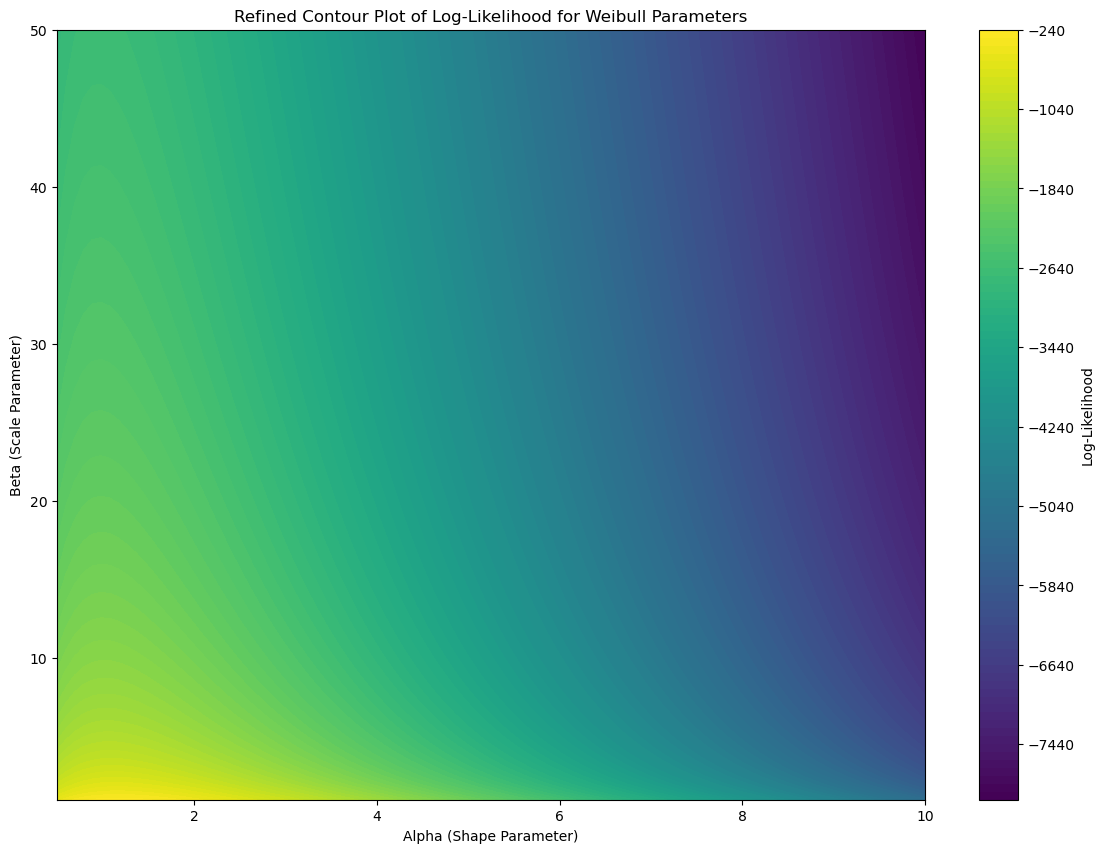

In [40]:
def log_likelihood(alpha, beta, data):
    if alpha <= 0 or beta <= 0:
        return -np.inf  # Return negative infinity for invalid parameters

    try:
        # Add epsilon to prevent log(0) errors
        epsilon = 1e-10
        log_likelihood_value = np.sum(np.log(alpha / (beta + epsilon)) + (alpha - 1) * np.log(data + epsilon) - (data / (beta + epsilon)) ** alpha)
        return log_likelihood_value
    except (OverflowError, FloatingPointError):
        return -np.inf  # Handle numerical issues gracefully

# Create a grid of alpha and beta values
alpha_values = np.linspace(0.5, 10, 100)  # Adjusted range for alpha
beta_values = np.linspace(1, 50, 100)     # Adjusted range for beta

log_likelihood_grid = np.zeros((len(alpha_values), len(beta_values)))

# Calculate the log-likelihood for each combination of alpha and beta
for i, alpha in enumerate(alpha_values):
    for j, beta in enumerate(beta_values):
        log_likelihood_grid[i, j] = log_likelihood(alpha, beta, df['time'])

# Create a detailed contour plot
plt.figure(figsize=(14, 10))
X, Y = np.meshgrid(alpha_values, beta_values)
plt.contourf(X, Y, log_likelihood_grid.T, levels=100, cmap='viridis')  # More levels for detailed visualization
plt.colorbar(label='Log-Likelihood')
plt.xlabel('Alpha (Shape Parameter)')
plt.ylabel('Beta (Scale Parameter)')
plt.title('Refined Contour Plot of Log-Likelihood for Weibull Parameters')
plt.show()

# Find the indices of the maximum log-likelihood in the grid
max_idx = np.unravel_index(np.argmax(log_likelihood_grid, axis=None), log_likelihood_grid.shape)
best_alpha = alpha_values[max_idx[0]]
best_beta = beta_values[max_idx[1]]

In [41]:
print(f"Best alpha (shape): {best_alpha:.2f}")
print(f"Best beta (scale): {best_beta:.2f}")

Best alpha (shape): 1.17
Best beta (scale): 1.00


<lifelines.WeibullFitter:"WeibullFitter", fitted with 686 total observations, 387 right-censored observations>
   number of observations = 686
number of events observed = 299
           log-likelihood = -279.45
               hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_  0.85      0.04            0.77            0.93
rho_     1.27      0.06            1.15            1.40

         cmp to     z      p  -log2(p)
lambda_    1.00 -3.47 <0.005     10.93
rho_       1.00  4.29 <0.005     15.78
---
AIC = 562.90

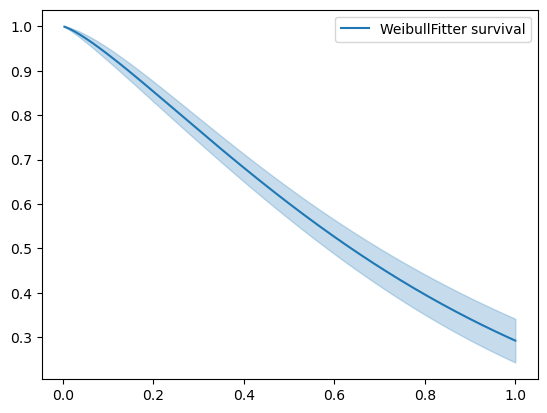

In [42]:
wbf = WeibullFitter().fit(df['time'], df['status'], label='WeibullFitter')
wbf.lambda_ = 1.5
wbf.rho_ = 0.5
wbf.plot_survival_function(label='WeibullFitter survival')
wbf.print_summary()

In [43]:
predicted_hazards = -(df['time'] / wbf.lambda_) ** wbf.rho_

c_index = concordance_index(df['time'], predicted_hazards, df['status'])
print(f"Manually Calculated Concordance Index (C-index): {c_index:.4f}")

Manually Calculated Concordance Index (C-index): 0.0002
